In [1]:
# Imports and setup

import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv("train.csv")
df_train, df_test = train_test_split(df, test_size=0.25, random_state=123)
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
660,661,1,1,"Frauenthal, Dr. Henry William",male,50.0,2,0,PC 17611,133.6500,NaN,S
852,853,0,3,"Boulos, Miss. Nourelain",female,9.0,1,1,2678,15.2458,NaN,C
703,704,0,3,"Gallagher, Mr. Martin",male,25.0,0,0,36864,7.7417,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
525,526,0,3,"Farrell, Mr. James",male,40.5,0,0,367232,7.7500,NaN,Q


# Explore the data to gain insight to get an idea of how to clean it and what potential information can be extracted:

In [3]:
# Explore amount of data, column information, missing, and duplicate rows in training set
df_train.info()
print(f"Duplicate rows: {df_train.duplicated().sum()}")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 668 entries, 660 to 510
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  668 non-null    int64  
 1   Survived     668 non-null    int64  
 2   Pclass       668 non-null    int64  
 3   Name         668 non-null    object 
 4   Sex          668 non-null    object 
 5   Age          529 non-null    float64
 6   SibSp        668 non-null    int64  
 7   Parch        668 non-null    int64  
 8   Ticket       668 non-null    object 
 9   Fare         668 non-null    float64
 10  Cabin        146 non-null    object 
 11  Embarked     666 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 67.8+ KB
Duplicate rows: 0


Observations: Over 75% of entries are missing the "Cabin" feature. Around 20% of entries are missing the "Age" feature. 2 entries are missing the "Embarked" feature. The cabin column will be dropped, while the missing values in the age column and embarked column will be imputed by regression.

In [4]:
# View statistics about each column
df_train.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,668.000000,668.000000,668.000000,668,668,529.000000,668.000000,668.000000,668,668.000000,146,666
unique,NaN,NaN,NaN,668,2,NaN,NaN,NaN,542,NaN,110,3
top,NaN,NaN,NaN,"Frauenthal, Dr. Henry William",male,NaN,NaN,NaN,CA. 2343,NaN,G6,S
freq,NaN,NaN,NaN,1,430,NaN,NaN,NaN,7,NaN,4,488
mean,440.474551,0.386228,2.324850,NaN,NaN,29.934329,0.526946,0.369760,NaN,32.790399,NaN,NaN
std,256.111554,0.487249,0.829106,NaN,NaN,14.378073,1.139791,0.781792,NaN,53.041537,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,217.750000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.925000,NaN,NaN
50%,442.500000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.427100,NaN,NaN
75%,654.250000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,30.500000,NaN,NaN


In [5]:
# View amount survived/not survived
df_train["Survived"].value_counts()

0    410
1    258
Name: Survived, dtype: int64

Classes are imbalanced -- 410 did not survive, while 258 did

In [6]:
# Drop columns that are of little use
df_train = df_train.drop(columns=["PassengerId", "Cabin"])

The "PassengerId" column is dropped as it does not provide any new insights about the data. The "Cabin" column is dropped as there is too much missing information relating to that feature.

In [7]:
# Transform the sex into 0/1 --> 0: male, 1: female
df_train["Sex"] = df_train["Sex"].map({"male": 0, "female": 1})

Encode the sex value as 0 for males and 1 for females so it can be used with the models.

In [8]:
# Impute missing values in "Embarked" with the value that occurs the most -- "S"
df_train["Embarked"] = df_train["Embarked"].fillna(df_train["Embarked"].mode())

In [9]:
# Create a new feature for number of family members on board, excluding themselves
# Combining SibSp and Parch columns
df_train["Family"] = df_train["SibSp"] + df_train["Parch"]

In [10]:
# Using the ticket class as an indicator of socio-economic status, we search for relationships between socio-economic status and other features
eco_status_group = df_train.groupby("Pclass").mean()
eco_status_group

,Survived,Sex,Age,SibSp,Parch,Fare,Family
Pclass,,,,,,,
1,0.634615,0.429487,38.645401,0.442308,0.358974,89.495272,0.801282
2,0.453237,0.410072,29.939769,0.395683,0.366906,20.778927,0.762590
3,0.257373,0.305630,25.376603,0.611260,0.375335,13.550814,0.986595


array([[<AxesSubplot:title={'center':'Survived'}, xlabel='Pclass'>,
        <AxesSubplot:title={'center':'Sex'}, xlabel='Pclass'>,
        <AxesSubplot:title={'center':'Age'}, xlabel='Pclass'>,
        <AxesSubplot:title={'center':'SibSp'}, xlabel='Pclass'>],
       [<AxesSubplot:title={'center':'Parch'}, xlabel='Pclass'>,
        <AxesSubplot:title={'center':'Fare'}, xlabel='Pclass'>,
        <AxesSubplot:title={'center':'Family'}, xlabel='Pclass'>,
        <AxesSubplot:xlabel='Pclass'>]], dtype=object)

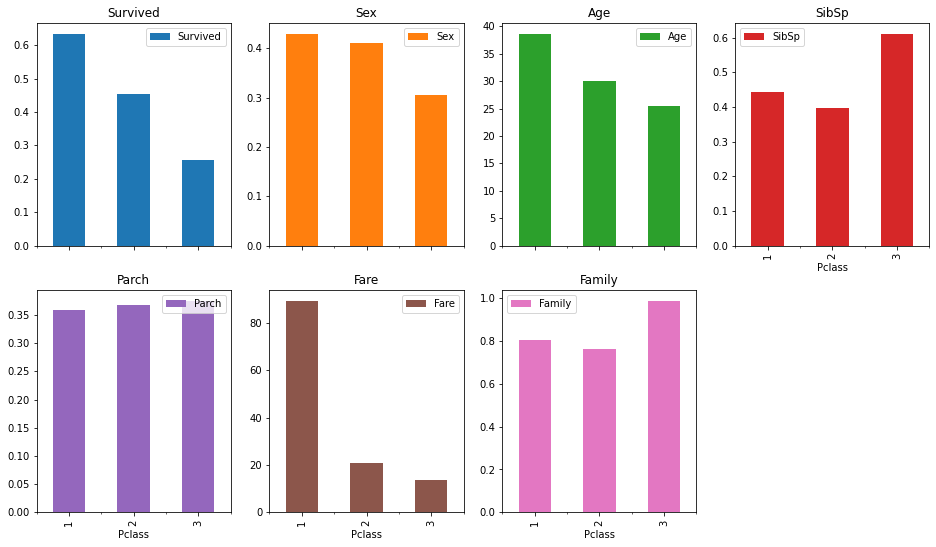

In [11]:
# Graphing these observations
eco_status_group.plot.bar(subplots=True, layout=(2,4), figsize=(16,9))

We can see clear trends when socio-economic status (ticket class) is plotted against the other (numerical) features. First, as expected, the fare decreases as ticket class increases (from 1 to 3), which is why ticket class is a decent measure of socio-economic status as poorer families would most likely prefer buying tickets of lower classes. As for the other trends, those of a lower economic status tend to have much lower survival rates, have more family members on board, tend to be younger, and tend to be males.

In [12]:
# We explore the distribution of survival victims in relation to age, gender, socioeconomic class, and number of family members on board
survival_group = df_train.groupby("Survived").mean()
survival_group

,Pclass,Sex,Age,SibSp,Parch,Fare,Family
Survived,,,,,,,
0,2.536585,0.151220,31.012945,0.563415,0.312195,22.576237,0.875610
1,1.988372,0.682171,28.419364,0.468992,0.461240,49.022207,0.930233


array([[<AxesSubplot:title={'center':'Pclass'}, xlabel='Survived'>,
        <AxesSubplot:title={'center':'Sex'}, xlabel='Survived'>,
        <AxesSubplot:title={'center':'Age'}, xlabel='Survived'>,
        <AxesSubplot:title={'center':'SibSp'}, xlabel='Survived'>],
       [<AxesSubplot:title={'center':'Parch'}, xlabel='Survived'>,
        <AxesSubplot:title={'center':'Fare'}, xlabel='Survived'>,
        <AxesSubplot:title={'center':'Family'}, xlabel='Survived'>,
        <AxesSubplot:xlabel='Survived'>]], dtype=object)

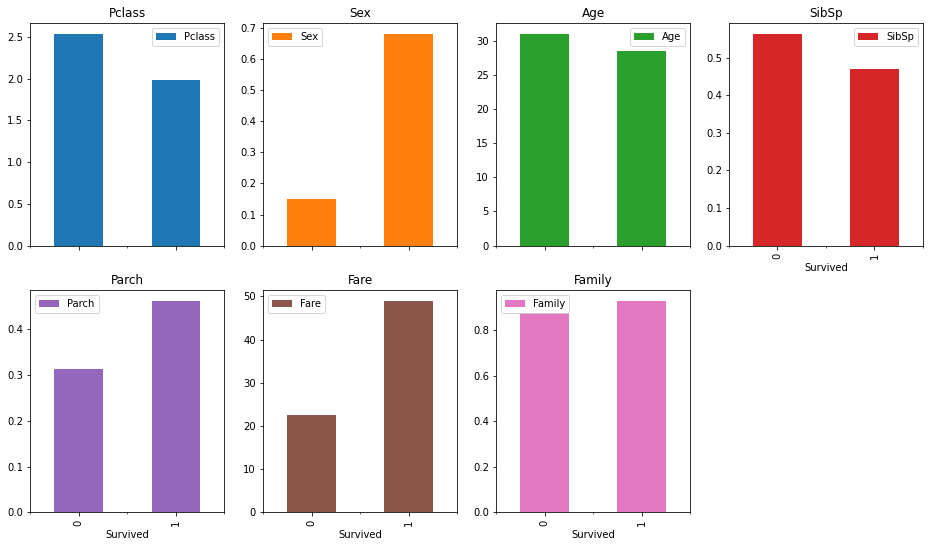

In [13]:
survival_group.plot.bar(subplots=True, layout=(2,4), figsize=(16,9))

We can also observe clear trends when plotting survival vs other features. It can be observed that those that survived tend to have paid a higher fare and are part of a higher ticket class (towards 1st class). They also vastly tend to be female. Those with parents/children on board tend to have higher survival rates and those with siblings/spouses tend to have lower survival rates, but overall, those with more family members on board tended to have higher survival rates. We also see that those who survived tend to be younger.

In [14]:
# We explore the relationships between sex and the other features
sex_group = df_train.groupby("Sex").mean()
sex_group

,Survived,Pclass,Age,SibSp,Parch,Fare,Family
Sex,,,,,,,
0,0.190698,2.395349,31.064595,0.427907,0.230233,26.563321,0.658140
1,0.739496,2.197479,28.014031,0.705882,0.621849,44.041003,1.327731


array([[<AxesSubplot:title={'center':'Survived'}, xlabel='Sex'>,
        <AxesSubplot:title={'center':'Pclass'}, xlabel='Sex'>,
        <AxesSubplot:title={'center':'Age'}, xlabel='Sex'>,
        <AxesSubplot:title={'center':'SibSp'}, xlabel='Sex'>],
       [<AxesSubplot:title={'center':'Parch'}, xlabel='Sex'>,
        <AxesSubplot:title={'center':'Fare'}, xlabel='Sex'>,
        <AxesSubplot:title={'center':'Family'}, xlabel='Sex'>,
        <AxesSubplot:xlabel='Sex'>]], dtype=object)

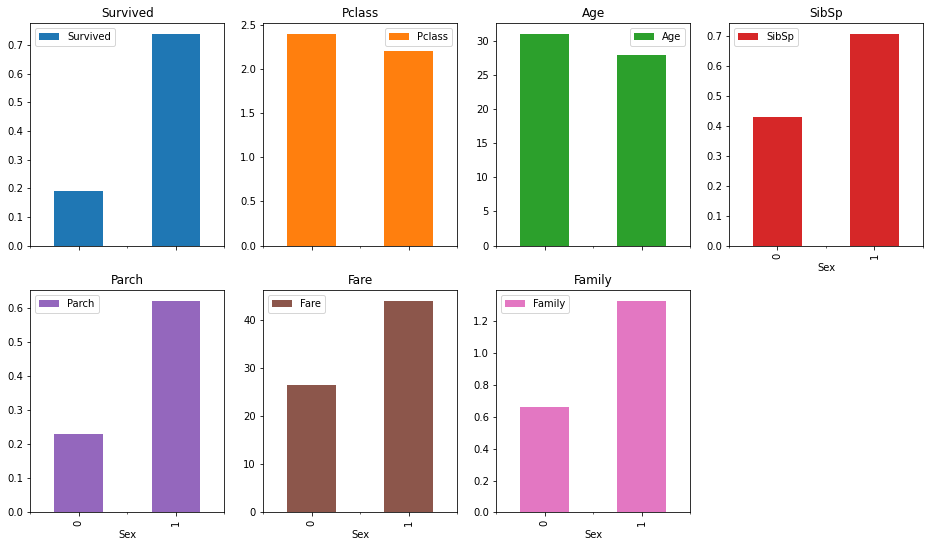

In [15]:
sex_group.plot.bar(subplots=True, layout=(2,4), figsize=(16,9))

We observe trends consistent with trends observed during the analysis of the other features above. Females tended to have a higher socio-economic status, are younger, and have more family on board. Those three tendencies correlate with having higher survival rates. This demonstrates that there is some multicollinearity between the features (the features are related to each other in some way).

In [16]:
# Create a correlation matrix to help determine important features
df_train.corr(method="spearman")

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family
Survived,1.000000,-0.320395,0.539801,-0.060399,0.086678,0.138633,0.305954,0.162893
Pclass,-0.320395,1.000000,-0.117888,-0.373305,-0.052970,-0.024165,-0.691786,-0.068877
Sex,0.539801,-0.117888,1.000000,-0.090372,0.190488,0.243240,0.240335,0.287382
Age,-0.060399,-0.373305,-0.090372,1.000000,-0.163490,-0.242869,0.159293,-0.210499
SibSp,0.086678,-0.052970,0.190488,-0.163490,1.000000,0.444461,0.444830,0.849650
Parch,0.138633,-0.024165,0.243240,-0.242869,0.444461,1.000000,0.398725,0.796089
Fare,0.305954,-0.691786,0.240335,0.159293,0.444830,0.398725,1.000000,0.514520
Family,0.162893,-0.068877,0.287382,-0.210499,0.849650,0.796089,0.514520,1.000000


<AxesSubplot:>

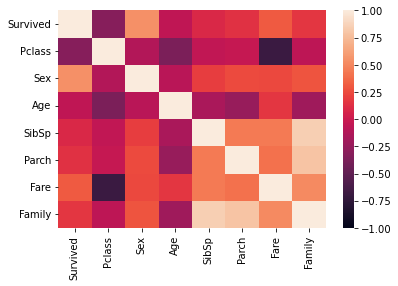

In [17]:
# Visual representation of the correlation matrix
sns.heatmap(df_train.corr(method="spearman"), vmin=-1, vmax=1)

From the correlation matrix, we see significant correlation with survival between ticket class, sex, and fare. We also see weaker correlation between number of family members and survival. There is barely any correlation with survival between number of parents/childrens aboard, age, and number of siblings/spouses on board. Additionally, since number of family members is a feature derived from the linear combination of "SibSp" and "Parch", the "SibSp" and "Parch" features can be removed to reduce multicollinearity effects.

In [18]:
# Drop categorical features to prepare the dataset for the modeling
df_train = df_train.drop(columns=["Name", "Ticket", "Embarked"])

# Drop "SibSp" and "Parch" as there is already the "Family" feature
df_train = df_train.drop(columns=["SibSp", "Parch"])

In [19]:
# Impute missing "Age" values using iterative imputation with Decision tree regressor
contains_age = df_train[df_train.Age.notnull()]
missing_age = df_train[df_train.Age.isnull()]

imp = IterativeImputer(estimator=DecisionTreeRegressor(), random_state=123).fit(contains_age)
missing_age = imp.transform(missing_age)
df_train.loc[df_train.Age.isnull()] = missing_age
df_train.describe()

,Survived,Pclass,Sex,Age,Fare,Family
count,668.000000,668.000000,668.000000,668.000000,668.000000,668.000000
mean,0.386228,2.324850,0.356287,29.698204,32.790399,0.896707
std,0.487249,0.829106,0.479260,13.862793,53.041537,1.633547
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,21.000000,7.925000,0.000000
50%,0.000000,3.000000,0.000000,29.000000,14.427100,0.000000
75%,1.000000,3.000000,1.000000,36.000000,30.500000,1.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,10.000000


# Modeling and Question Answering:

In [20]:
# Create the "Family" feature that was created in the training set for the test set
df_test["Family"] = df_test["SibSp"] + df_test["Parch"]

# Encode the sex values to 0/1, 0--> male, 1--> female
df_test["Sex"] = df_test["Sex"].map({"male": 0, "female": 1})

# Drop the same features in the test set that were dropped in the training set
df_test = df_test.drop(columns=["Cabin", "Embarked", "Name", "PassengerId", "Ticket", "SibSp", "Parch"])

In [21]:
# Use the same iterative imputation model to fill null age data in the test set
missing_age_test = imp.transform(df_test[df_test.Age.isnull()])
df_test.loc[df_test.Age.isnull()] = missing_age_test
df_test.describe()

,Survived,Pclass,Sex,Age,Fare,Family
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.376682,2.260090,0.340807,29.435284,30.448263,0.928251
std,0.485644,0.856651,0.475047,14.901339,37.986528,1.555073
min,0.000000,1.000000,0.000000,0.750000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,20.000000,7.895800,0.000000
50%,0.000000,3.000000,0.000000,28.000000,15.741700,0.000000
75%,1.000000,3.000000,1.000000,39.500000,33.250000,1.000000
max,1.000000,3.000000,1.000000,71.000000,247.520800,7.000000


In [22]:
# Split the data in X and y
df_train_X = df_train.drop(columns="Survived")
df_train_y = df_train.Survived
df_test_X = df_test.drop(columns="Survived")
df_test_y = df_test.Survived

In [23]:
# Scale the features so they work better with the models
scaler = StandardScaler().fit(df_train_X)
feature_names = scaler.get_feature_names_out()
df_train_X = pd.DataFrame(scaler.transform(df_train_X), columns=feature_names)
df_test_X = pd.DataFrame(scaler.transform(df_test_X), columns=feature_names)

## 1. Regularized Logistic Regression

Logistic regression is a classification algorithm -- which is a method to find the best decision boundary between two classes

In [24]:
# Perform a logistic regression on the dataset
logistic_clf = LogisticRegression().fit(df_train_X, df_train_y)
pred = logistic_clf.predict(df_test_X)

In [25]:
# Evaluation metrics for the logistic regression model
accuracy = logistic_clf.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}")

Accuracy: 0.7937219730941704
Precision: 0.7435897435897436
Recall: 0.6904761904761905
F-Score: 0.7160493827160495


## 1a. Regularized Logistic Regression with CV

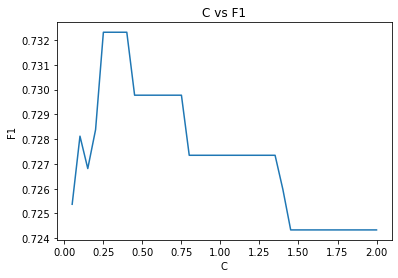

In [26]:
# Find the optimal value of C for logisitic regression using CV with F1 scoring
c_vals = np.linspace(0.05, 2, 40)
f1_vals = []
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
for c in c_vals:
    logistic_clf = LogisticRegression(C=c).fit(df_train_X, df_train_y)
    f1 = cross_val_score(logistic_clf, df_train_X, df_train_y, scoring="f1", cv=cv)
    f1_vals.append(f1.mean())
plt.title("C vs F1")
plt.xlabel("C")
plt.ylabel("F1")
plt.plot(c_vals, f1_vals)    

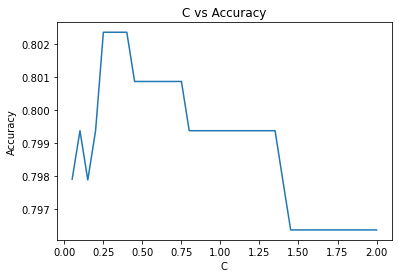

In [27]:
# Find the optimal value of C for logisitic regression using CV with accuracy scoring
c_vals = np.linspace(0.05, 2, 40)
f1_vals = []
for c in c_vals:
    logistic_clf = LogisticRegression(C=c).fit(df_train_X, df_train_y)
    f1 = cross_val_score(logistic_clf, df_train_X, df_train_y, scoring="accuracy", cv=cv)
    f1_vals.append(f1.mean())
plt.title("C vs Accuracy")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.plot(c_vals, f1_vals)    

Using CV, we find that an optimal value of C (inverse of lambda -- the regularization parameter) is 0.3.

In [28]:
# Perform logistic regression with C=0.3
logistic_clf = LogisticRegression(C=0.3).fit(df_train_X, df_train_y)
pred = logistic_clf.predict(df_test_X)
accuracy = logistic_clf.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}")

Accuracy: 0.7937219730941704
Precision: 0.7435897435897436
Recall: 0.6904761904761905
F-Score: 0.7160493827160495


No change in the metrics after using the optimal hyperparameter, C, obtained from CV

## 2. K-Nearest Neighbors

An observation is classified by the most common class among its k nearest neighbors

In [29]:
# Implement a k nearest neighbors vote on the data
knn = KNeighborsClassifier().fit(df_train_X, df_train_y)
pred = knn.predict(df_test_X)

In [30]:
# Evaluation metrics for the k nearest neighbors vote
accuracy = knn.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}")

Accuracy: 0.8609865470852018
Precision: 0.8441558441558441
Recall: 0.7738095238095238
F-Score: 0.8074534161490684


## 2a. KNN with CV

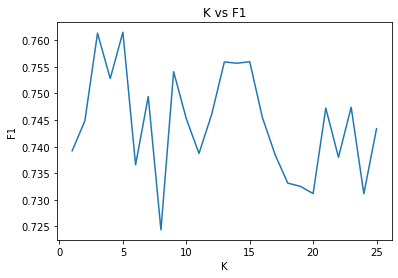

In [31]:
# Find the optimal K for KNN using CV using F1 scoring
k_vals = [i for i in range(1, 26)]
f1_vals = []
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k).fit(df_train_X, df_train_y)
    f1 = cross_val_score(knn, df_train_X, df_train_y, scoring="f1", cv=cv)
    f1_vals.append(f1.mean())
plt.title("K vs F1")
plt.xlabel("K")
plt.ylabel("F1")
plt.plot(k_vals, f1_vals)

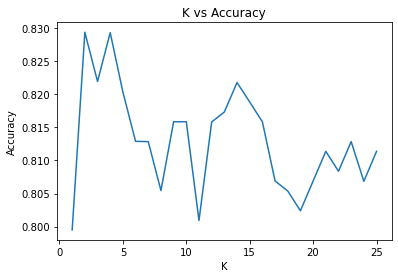

In [32]:
# Find the optimal K for KNN using CV using accuracy scoring
k_vals = [i for i in range(1, 26)]
f1_vals = []
for k in k_vals:
    knn = KNeighborsClassifier(n_neighbors=k).fit(df_train_X, df_train_y)
    f1 = cross_val_score(knn, df_train_X, df_train_y, scoring="accuracy", cv=cv)
    f1_vals.append(f1.mean())
plt.title("K vs Accuracy")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.plot(k_vals, f1_vals)

Using CV, we find that K=5 maximizes F1 score, while a lower value of K=2 maximizes accuracy

In [33]:
# Perform KNN vote with K=2
knn = KNeighborsClassifier(n_neighbors=2).fit(df_train_X, df_train_y)
pred = knn.predict(df_test_X)
accuracy = knn.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"KNN with K=2\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}\n")

# Perform KNN vote with K=5
knn = KNeighborsClassifier(n_neighbors=5).fit(df_train_X, df_train_y)
pred = knn.predict(df_test_X)
accuracy = knn.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"KNN with K=5\nAccuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}")

KNN with K=2
Accuracy: 0.8026905829596412
Precision: 0.8225806451612904
Recall: 0.6071428571428571
F-Score: 0.6986301369863014

KNN with K=5
Accuracy: 0.8609865470852018
Precision: 0.8441558441558441
Recall: 0.7738095238095238
F-Score: 0.8074534161490684


We find that using CV to tune K yields a poorer performance by the model compared to the baseline of K=5. 

## 3. Multilayer Perceptron

A perceptron takes a weighted sum of the inputs, applies a function to the weighted sum, and returns an output. An MLP contains multiple layers of perceptrons: the input layer, hidden layers, and output layer.

In [34]:
# Implement a multi-layer perceptron on the data
mlp_clf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=(8,), random_state=123, max_iter=800).fit(df_train_X, df_train_y)
pred = mlp_clf.predict(df_test_X)

In [35]:
# Evaluation metrics for the MLP model
accuracy = mlp_clf.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}")

Accuracy: 0.8385650224215246
Precision: 0.8
Recall: 0.7619047619047619
F-Score: 0.7804878048780488


The KNN model performed the best in all metrics, while the regularized logistic regression model performed the worst in all metrics.

## 3a. MLP with CV

In [36]:
# Find the optimal alpha (regularization term) and optimal number of neurons in first hidden layer
mlp_clf = MLPClassifier(solver="lbfgs", random_state=123, max_iter=1000)
parameter_space = {
    "hidden_layer_sizes": [(i,) for i in range(2, 16)],
    "alpha": np.geomspace(0.00001, 2, 25),
}
clf = GridSearchCV(mlp_clf, parameter_space, cv=cv, n_jobs=-1, scoring="f1")
clf.fit(df_train_X, df_train_y)

print(f"Best parameters:\n{clf.best_params_}")

Best parameters:
{'alpha': 0.4349118552081964, 'hidden_layer_sizes': (14,)}


In [37]:
mlp_clf = MLPClassifier(solver="lbfgs", hidden_layer_sizes=clf.best_params_["hidden_layer_sizes"], alpha=clf.best_params_["alpha"], random_state=123, max_iter=1000).fit(df_train_X, df_train_y)
pred = mlp_clf.predict(df_test_X)
accuracy = mlp_clf.score(df_test_X, df_test_y)
precision, recall, f1, _ = precision_recall_fscore_support(df_test_y, pred, average="binary")
print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF-Score: {f1}")

Accuracy: 0.8430493273542601
Precision: 0.810126582278481
Recall: 0.7619047619047619
F-Score: 0.7852760736196319


MLP with CV tended to perform better in all metrics by a few percentage points.